<a href="https://colab.research.google.com/github/lucianolcp/projetosbootcamp/blob/main/Projetos/Sprint_13_S%C3%A9ries_Temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descrição do Projeto

A empresa Sweet Lift Taxi coletou dados históricos sobre pedidos de táxi nos aeroportos. Para atrair mais motoristas durante o horário de pico, precisamos prever a quantidade de pedidos de táxi para a próxima hora.
Construa um modelo para tal predição.

A métrica REQM no conjunto de teste não deve ser superior a 48.

## Instruções do projeto

1. Faça download dos dados e faça uma nova amostragem em uma hora.
2. Analise os dados
3. Treine diferentes modelos com diferentes hiperparâmetros. A amostra de teste deve ser 10% do conjunto de dados inicial.
4. Teste os dados usando a amostra de teste e forneça uma conclusão.

## Descrição dos dados

Os dados são armazenados no arquivo `taxi.csv`. O número de pedidos está na coluna `num_orders`.

## Preparação

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

# Importando libs de plots
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
# sns.set_context('talk')
sns.set_palette('rainbow')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [ ]:
#statistics libraries
import statsmodels.api as sm
import scipy
from scipy.stats import anderson
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
#from nimbusml.timeseries import SsaForecaster
from statsmodels.tsa.statespace.tools import diff as diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import signal
from scipy.stats import shapiro
from scipy.stats import boxcox
import scipy.stats as stats
from scipy.stats import jarque_bera as jb
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [ ]:
# Carregando os dados
df = pd.read_csv('/datasets/taxi.csv')

# Exibindo as primeiras linhas do DataFrame
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [ ]:
print(df['datetime'].min())
print(df['datetime'].max())

2018-03-01 00:00:00
2018-08-31 23:50:00


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None


In [ ]:
# Convertendo a coluna 'datetime' para o tipo datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Definindo a coluna 'datetime' como índice
df.set_index('datetime', inplace=True)

# Reamostrando os dados para intervalos de 1 hora, somando o número de pedidos em cada intervalo
df = df.resample('1H').sum()

# Exibindo as primeiras linhas do DataFrame reamostrado
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [ ]:
# Resumo estatístico
print(df.describe())

        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


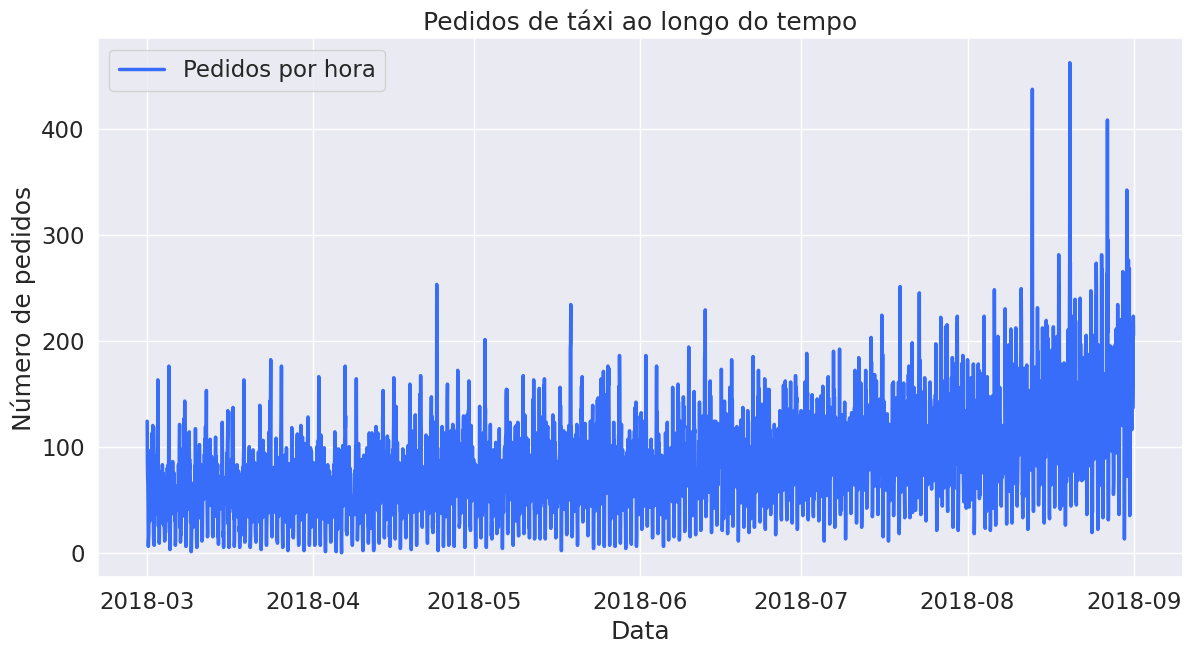

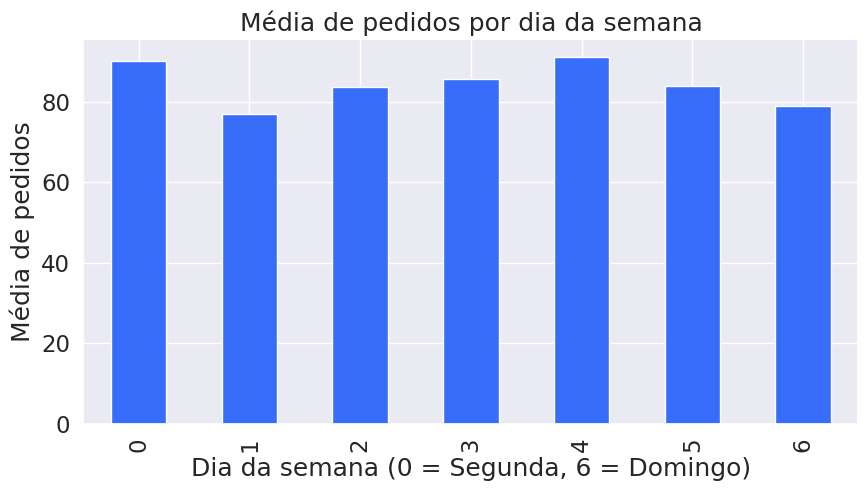

In [ ]:
# Visualização temporal dos dados
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['num_orders'], label='Pedidos por hora')
plt.title('Pedidos de táxi ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Número de pedidos')
plt.legend()
plt.grid(True)
plt.show()

# Verificação de sazonalidade (por dia da semana)
df['day_of_week'] = df.index.dayofweek
df.groupby('day_of_week')['num_orders'].mean().plot(kind='bar', figsize=(10, 5), title='Média de pedidos por dia da semana')
plt.xlabel('Dia da semana (0 = Segunda, 6 = Domingo)')
plt.ylabel('Média de pedidos')
plt.grid(True)
plt.show()


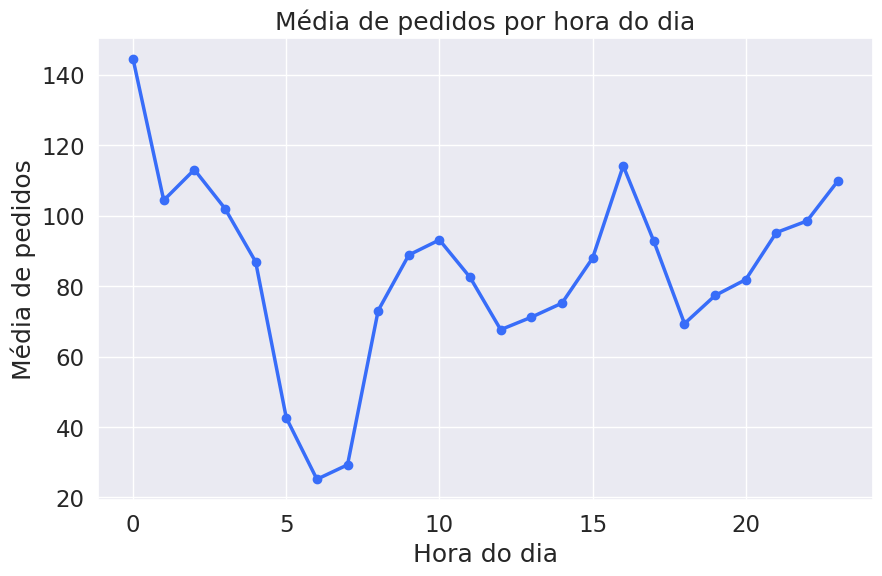

In [ ]:
# Adicionar uma coluna para a hora do dia
df['hour'] = df.index.hour

# Calcular a média de pedidos por hora do dia
mean_orders_by_hour = df.groupby('hour')['num_orders'].mean()

# Plotar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(mean_orders_by_hour.index, mean_orders_by_hour.values, marker='o')
plt.title('Média de pedidos por hora do dia')
plt.xlabel('Hora do dia')
plt.ylabel('Média de pedidos')
plt.grid(True)
plt.show()

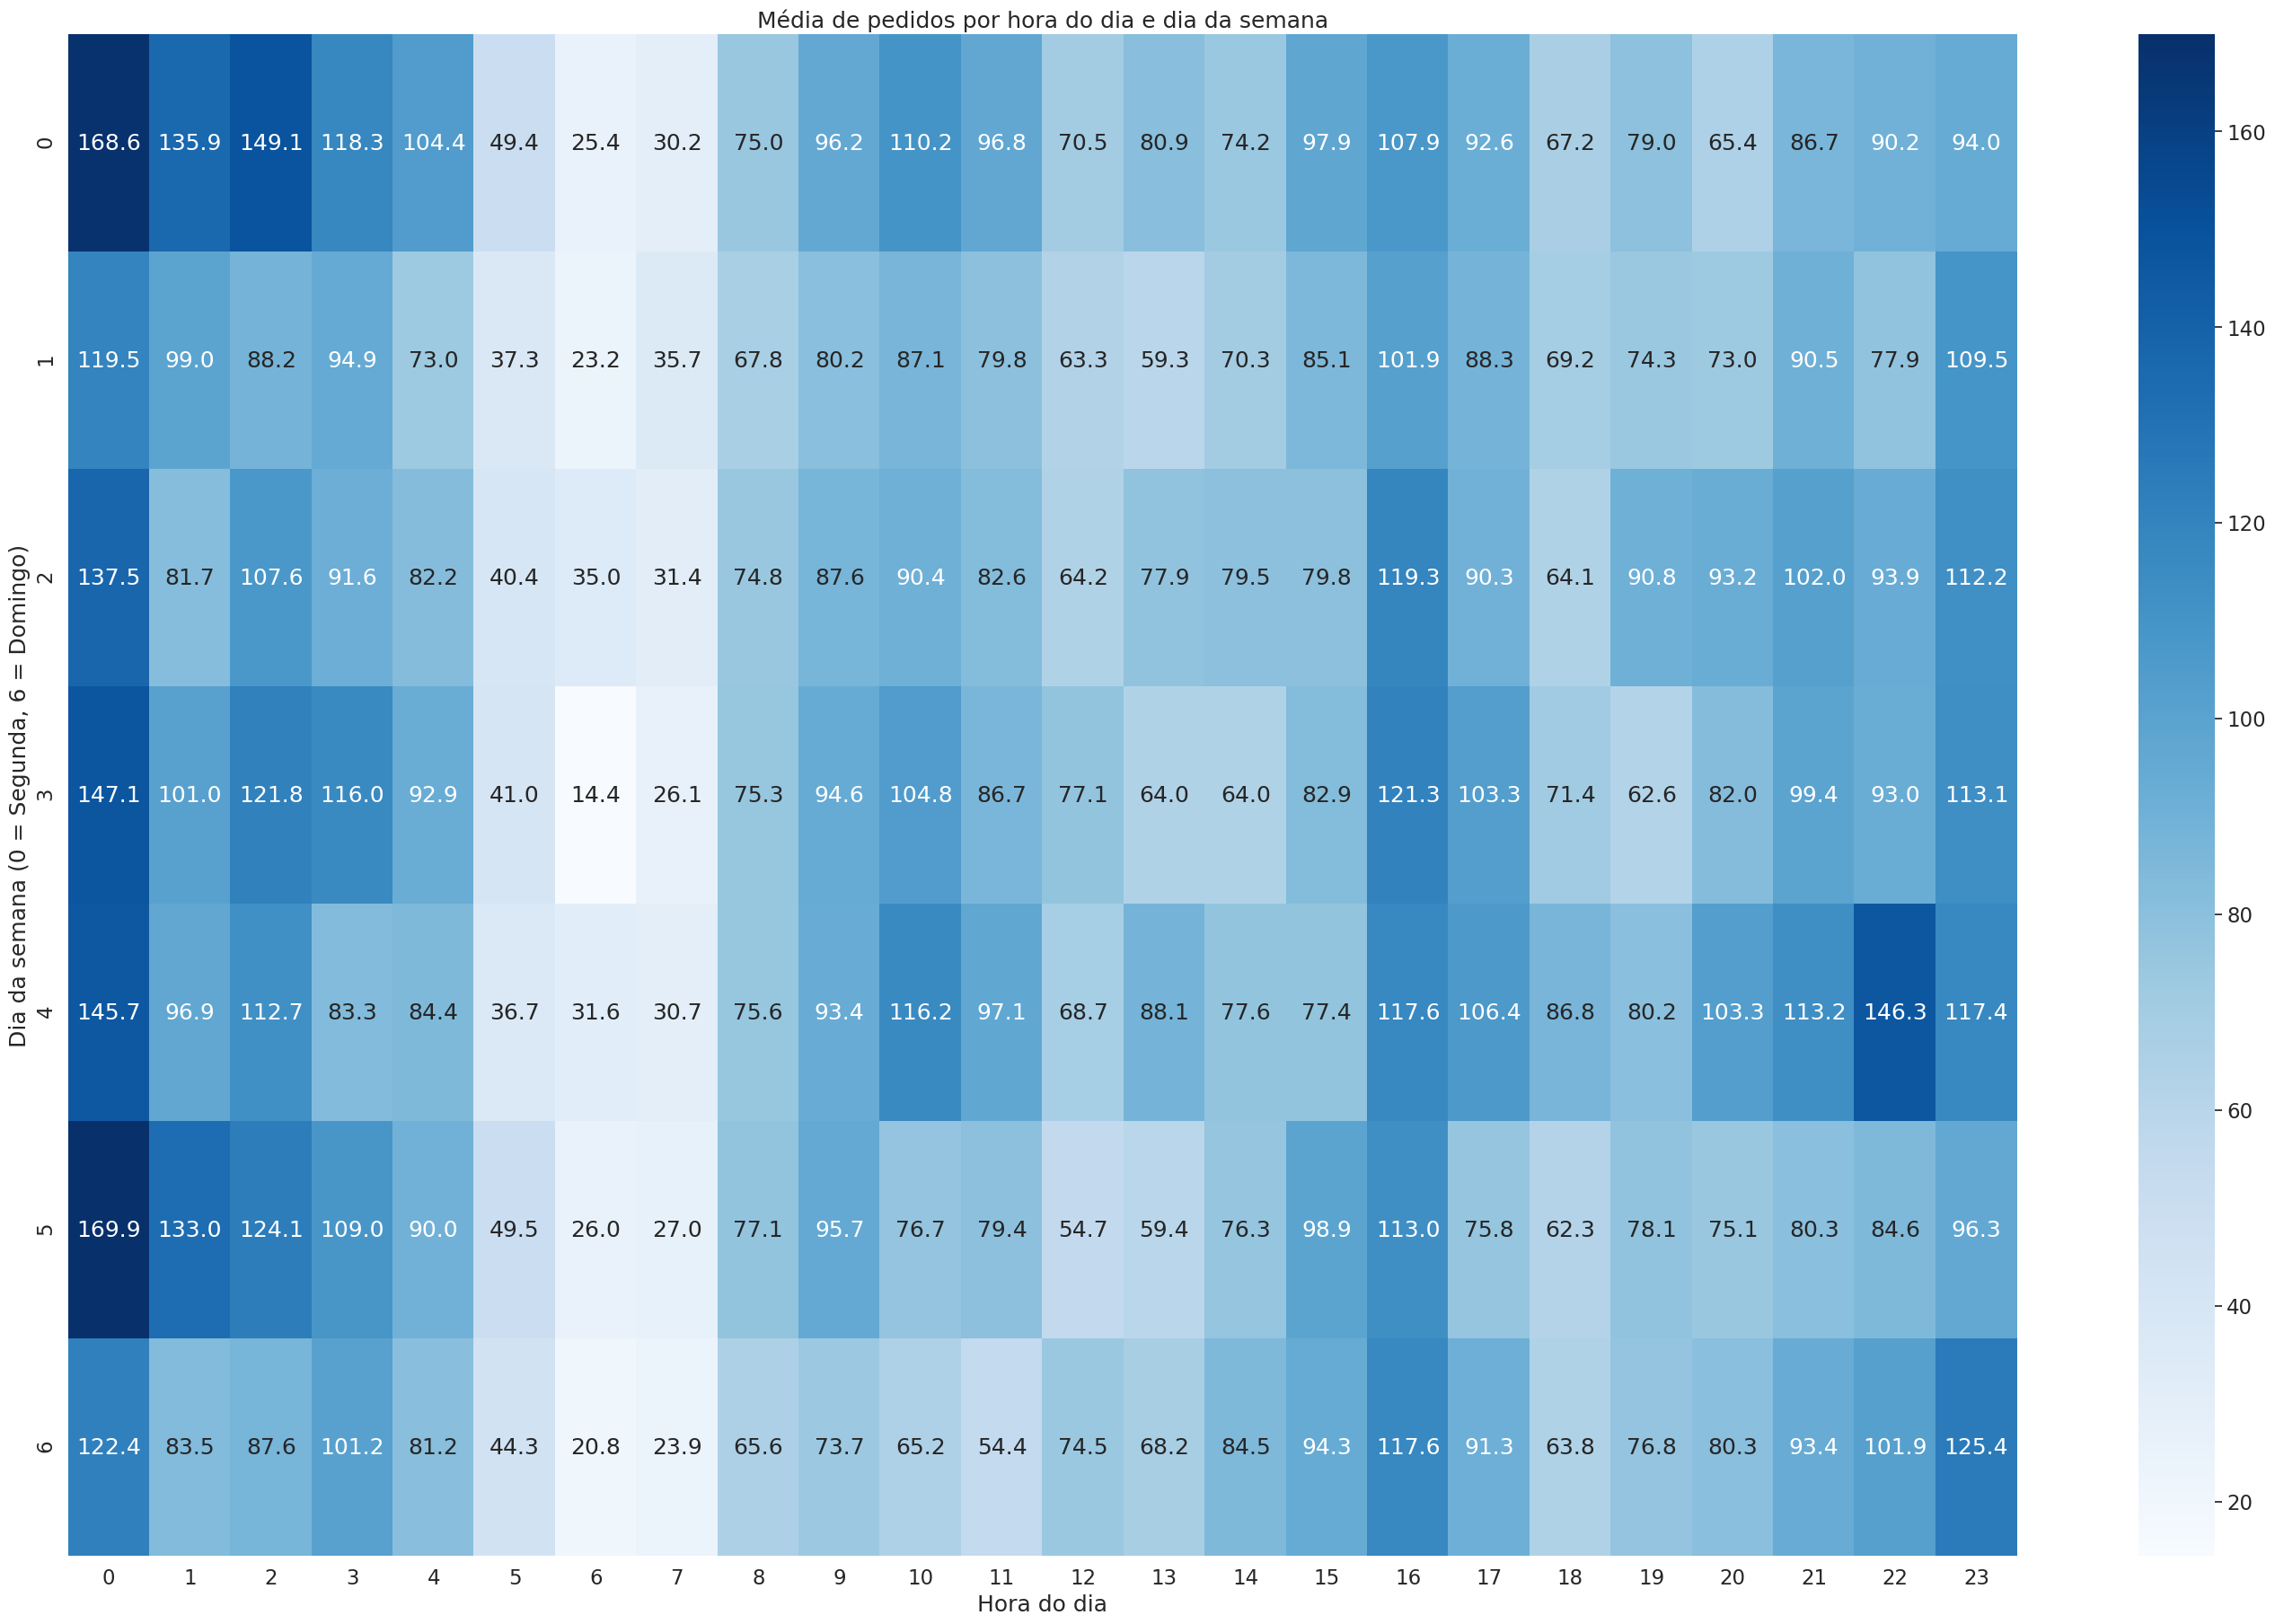

In [ ]:
# Adicionar uma coluna para o dia da semana
df['day_of_week'] = df.index.dayofweek

# Calcular a média de pedidos por hora e por dia da semana
mean_orders_by_hour_day = df.groupby(['day_of_week', 'hour'])['num_orders'].mean().unstack()

# Plotar o gráfico
plt.figure(figsize=(35, 22))
sns.heatmap(mean_orders_by_hour_day, cmap='Blues', annot=True, fmt=".1f")
plt.title('Média de pedidos por hora do dia e dia da semana')
plt.xlabel('Hora do dia')
plt.ylabel('Dia da semana (0 = Segunda, 6 = Domingo)')
plt.show()

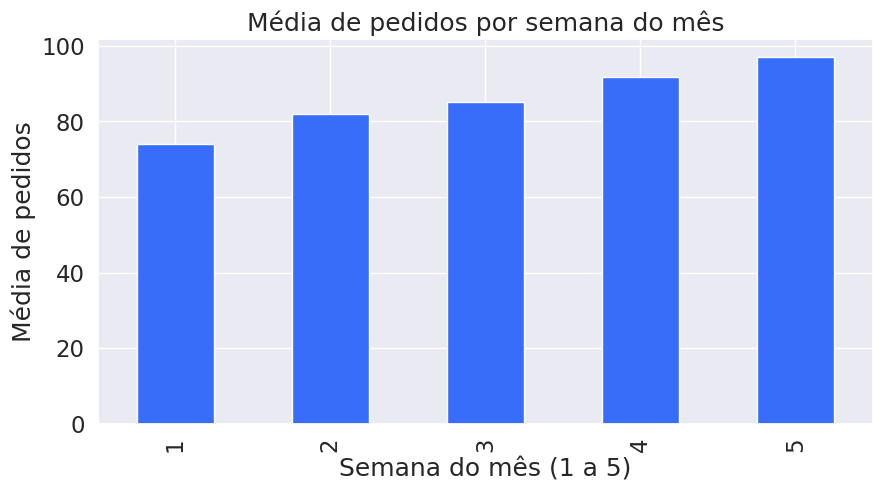

In [ ]:
# Adicionar uma coluna para a semana do mês
df['week_of_month'] = (df.index.day - 1) // 7 + 1

# Calcular a média de pedidos por semana do mês
mean_orders_by_week = df.groupby('week_of_month')['num_orders'].mean()

# Plotar o gráfico
mean_orders_by_week.plot(kind='bar', figsize=(10, 5), title='Média de pedidos por semana do mês')
plt.xlabel('Semana do mês (1 a 5)')
plt.ylabel('Média de pedidos')
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

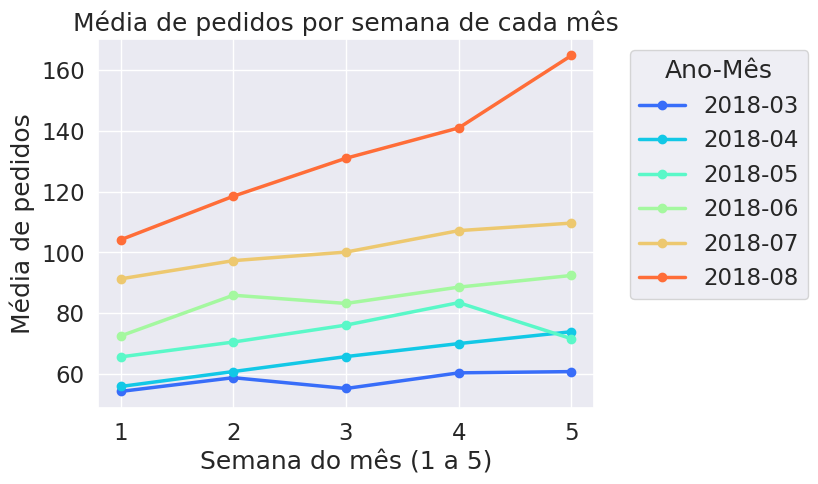

In [ ]:
# Criar uma cópia do DataFrame original
df_copy = df.copy()

# Adicionar a coluna 'month' ao DataFrame copiado
df_copy['month'] = df_copy.index.to_period('M')

# Calcular a média de pedidos por semana e mês
mean_orders_by_week_month = df_copy.groupby(['month', 'week_of_month'])['num_orders'].mean().unstack()

# Plotar o gráfico
plt.figure(figsize=(12, 6))
mean_orders_by_week_month.T.plot(kind='line', marker='o')
plt.title('Média de pedidos por semana de cada mês')
plt.xlabel('Semana do mês (1 a 5)')
plt.ylabel('Média de pedidos')
plt.grid(True)
plt.legend(title='Ano-Mês', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


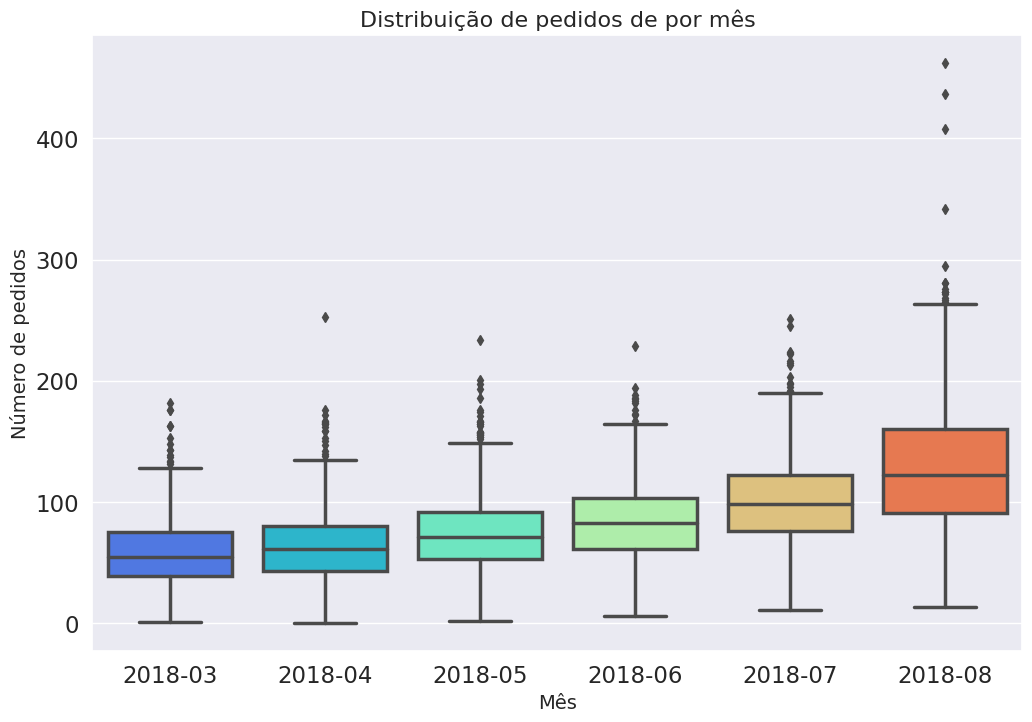

In [ ]:
# Configuração do tamanho da figura
plt.figure(figsize=(12, 8))

# Plotar o gráfico de caixa (boxplot)
sns.boxplot(x='month', y='num_orders', data=df_copy)

# Adicionar título e rótulos
plt.title('Distribuição de pedidos de por mês', fontsize=16)
plt.xlabel('Mês', fontsize=14)
plt.ylabel('Número de pedidos', fontsize=14)

# Mostrar o gráfico
plt.show()

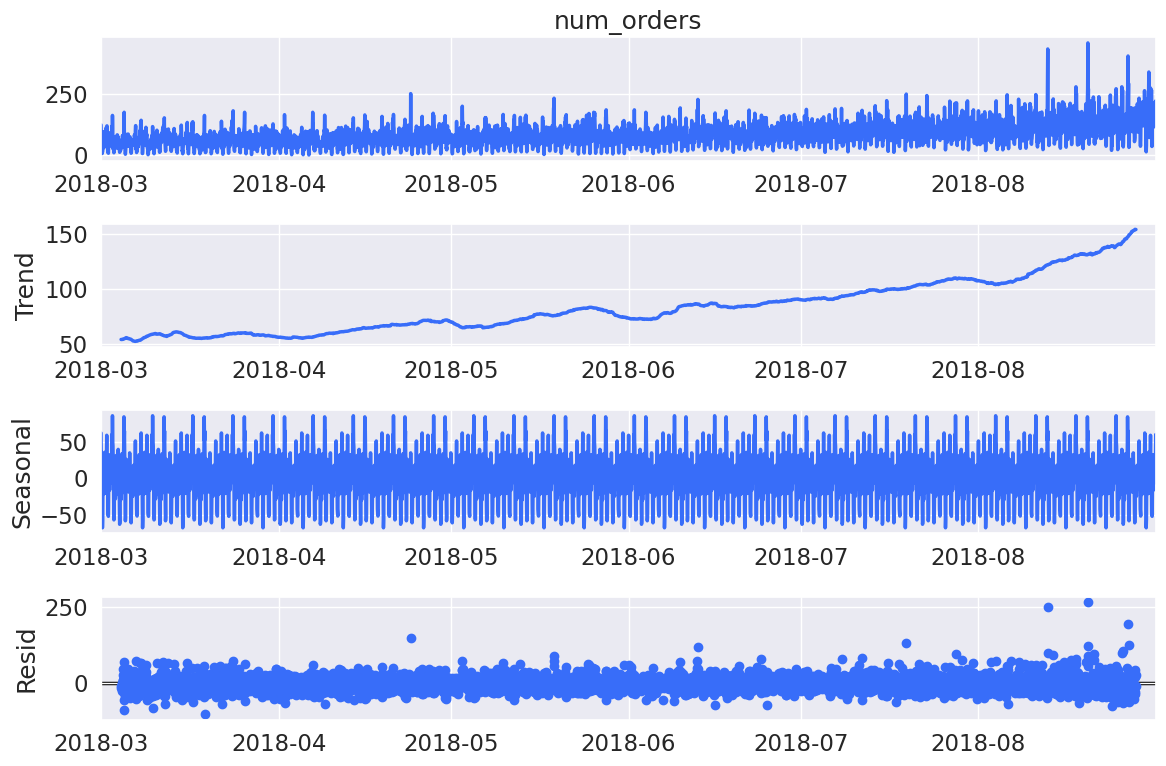

In [ ]:
df.index = pd.to_datetime(df.index)

# Realizando a decomposição sazonal com sazonalidade semanal (168 horas)
result = seasonal_decompose(df['num_orders'], model='additive', period=168)

# Plotando os componentes
plt.rcParams['figure.figsize'] = (12, 8);
result.plot()
plt.show()

# Acessando os componentes individualmente
trend = result.trend
seasonal = result.seasonal
residual = result.resid


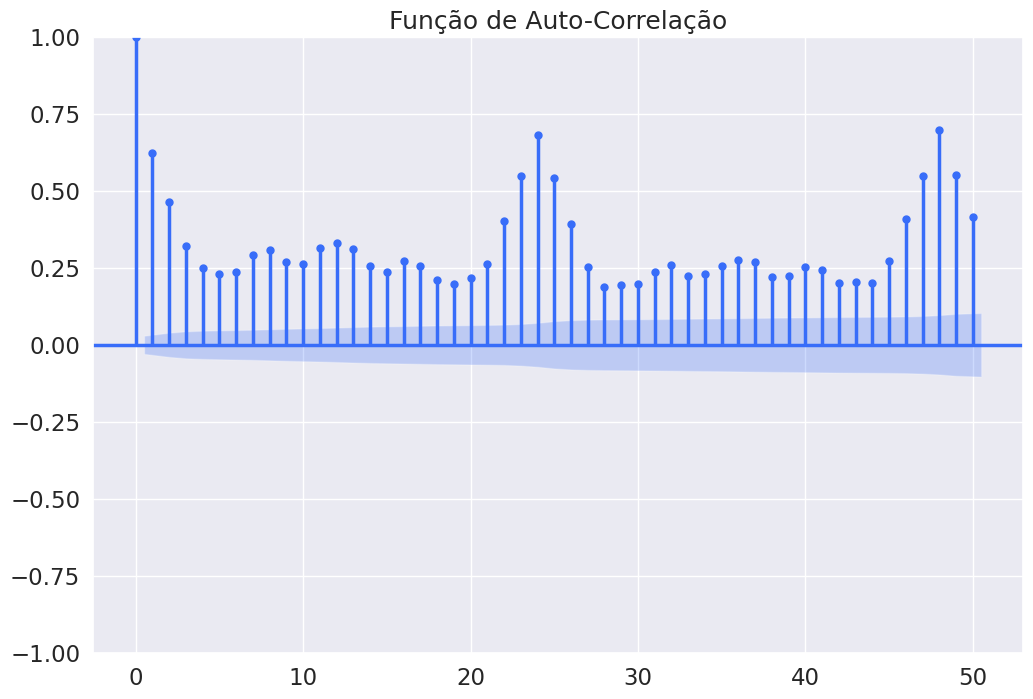

In [ ]:
# Extrair a série temporal
serie_temporal = df['num_orders']

# Plotar a função de auto-correlação
plot_acf(serie_temporal.dropna(), lags=50)  # Ajuste o número de lags conforme necessário
plt.title('Função de Auto-Correlação')
plt.show()

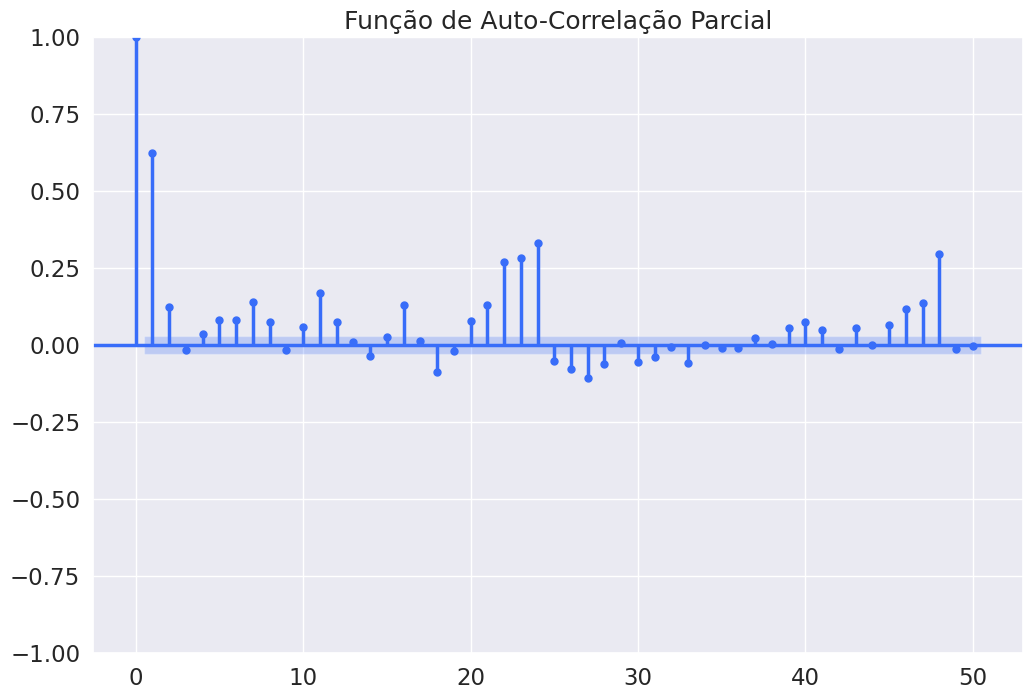

In [ ]:
# Plotar a função de auto-correlação parcial
plot_pacf(serie_temporal.dropna(), lags=50)
plt.title('Função de Auto-Correlação Parcial')
plt.show()

In [ ]:
df = df.reset_index()

## Análise

*Tendência e sazonalidade*: Os dados apresentam uma tendência crescente e uma sazonalidade diária e semanal clara, o que indica que o modelo precisa capturar essas duas características.

*Outliers*: Existem picos nos dados que precisam ser analisados para decidir se serão mantidos ou removidos. A princípio serão mantidos.

*Fatores temporais*: Variáveis como dia da semana, hora do dia e semana do mês parecem ser boas candidatas para features importantes no modelo.

*Modelo AR*: A PACF sugere que um modelo auto-regressivo simples pode capturar boa parte da dependência temporal. Podemos explorar um modelo ARIMA com uma componente AR para começar.

## Treinamento

### ARIMA/SARIMAX

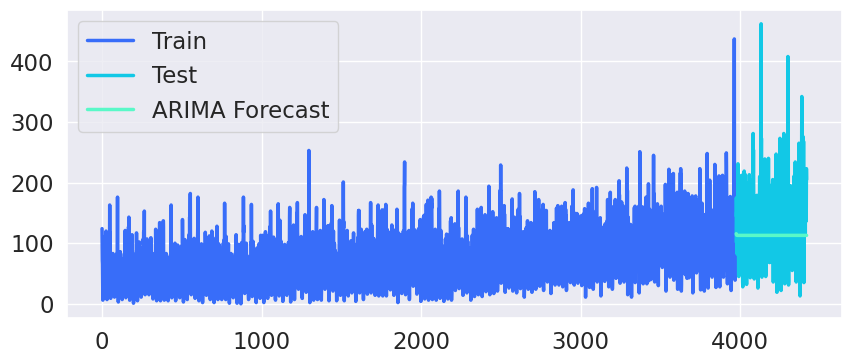

ARIMA REQM: 64.3285
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.65123D+00    |proj g|=  7.64820D-02


 This problem is unconstrained.



At iterate    5    f=  4.58621D+00    |proj g|=  3.57876D-02

At iterate   10    f=  4.49436D+00    |proj g|=  1.45487D-02

At iterate   15    f=  4.49187D+00    |proj g|=  1.07787D-03

At iterate   20    f=  4.48910D+00    |proj g|=  3.10354D-02

At iterate   25    f=  4.48790D+00    |proj g|=  2.05646D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     39      1     0     0   6.302D-06   4.488D+00
  F =   4.4878982866933796     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


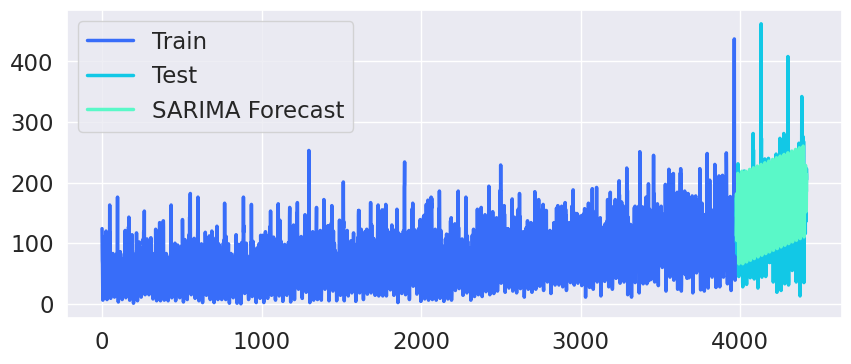

SARIMA REQM: 44.4601


In [ ]:
# Mantendo sua divisão, mas sem embaralhar os dados
X = df.drop(columns=['num_orders', 'datetime'])  # Removendo datetime para este exemplo
y = df['num_orders']

# Aqui, fazemos a divisão sem embaralhar os dados
split_index = int(0.9 * len(df))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Treinando o modelo ARIMA
arima_model = ARIMA(y_train, order=(1, 1, 1))  # Os parâmetros (p, d, q) podem ser ajustados
arima_model_fit = arima_model.fit()

# Fazendo previsões no conjunto de teste
arima_forecast = arima_model_fit.forecast(steps=len(y_test))

# Plotando os resultados
plt.figure(figsize=(10, 4))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.show()

# Calculando REQM
arima_reqm = np.sqrt(mean_squared_error(y_test, arima_forecast))
print(f'ARIMA REQM: {arima_reqm:.4f}')

# Modelo SARIMA
sarima_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
sarima_model_fit = sarima_model.fit()

# Fazendo previsões no conjunto de teste
sarima_forecast = sarima_model_fit.forecast(steps=len(y_test))

# Plotando os resultados do SARIMA
plt.figure(figsize=(10, 4))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, sarima_forecast, label='SARIMA Forecast')
plt.legend()
plt.show()

# Calculando REQM para o SARIMA
sarima_reqm = np.sqrt(mean_squared_error(y_test, sarima_forecast))
print(f'SARIMA REQM: {sarima_reqm:.4f}')


### Prophet

In [ ]:
pip install --user prophet

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from prophet import Prophet

In [ ]:
# Preparando os dados para o Prophet
df_prophet = df[['datetime', 'num_orders']].rename(columns={'datetime': 'ds', 'num_orders': 'y'})

# Separando os dados em treino e teste
train_data = df_prophet.iloc[:split_index]
test_data = df_prophet.iloc[split_index:]



22:15:57 - cmdstanpy - INFO - Chain [1] start processing
22:15:57 - cmdstanpy - INFO - Chain [1] done processing


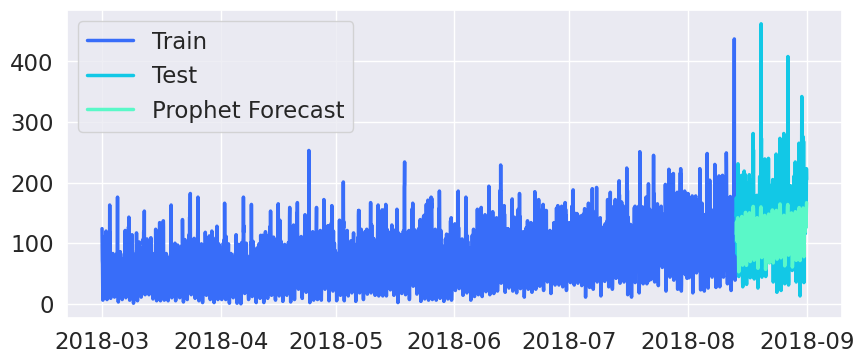

Prophet REQM: 48.2458


In [ ]:
# Treinando o modelo Prophet
prophet_model = Prophet()
prophet_model.fit(train_data)

# Fazendo previsões
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='H')
forecast = prophet_model.predict(future)

# Extraindo as previsões para o período de teste
forecast_test = forecast.iloc[-len(test_data):]['yhat'].values

# Plotando os resultados
plt.figure(figsize=(10, 4))
plt.plot(train_data['ds'], train_data['y'], label='Train')
plt.plot(test_data['ds'], test_data['y'], label='Test')
plt.plot(test_data['ds'], forecast_test, label='Prophet Forecast')
plt.legend()
plt.show()

# Calculando o REQM
prophet_reqm = np.sqrt(mean_squared_error(test_data['y'], forecast_test))
print(f'Prophet REQM: {prophet_reqm:.4f}')

22:15:59 - cmdstanpy - INFO - Chain [1] start processing
22:15:59 - cmdstanpy - INFO - Chain [1] done processing


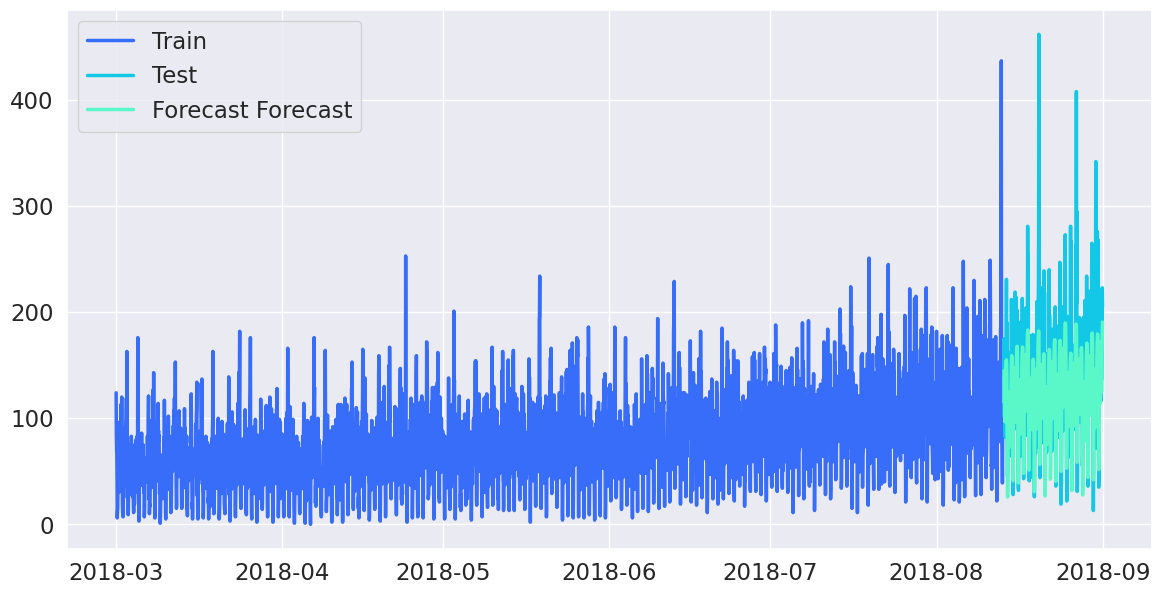

Prophet REQM (ajustado): 44.4765


In [ ]:
# Ajustando hiperparâmetros do Prophet
prophet_model = Prophet(
    seasonality_mode='multiplicative',  # Modo de sazonalidade
    yearly_seasonality=False,            # Ativa sazonalidade anual
    weekly_seasonality=True,            # Ativa sazonalidade semanal
    daily_seasonality=True              # Ativa sazonalidade diária
)

# Treinando o modelo Prophet com os novos parâmetros
prophet_model.fit(train_data)

# Fazendo previsões
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='H')
forecast = prophet_model.predict(future)

# Extraindo as previsões para o período de teste
forecast_test = forecast.iloc[-len(test_data):]['yhat'].values

# Criando o gráfico
plt.figure(figsize=(14, 7))
plt.plot(train_data['ds'], train_data['y'], label='Train')
plt.plot(test_data['ds'], test_data['y'], label='Test')
plt.plot(test_data['ds'], forecast_test, label='Forecast Forecast')
plt.legend()
plt.show()

# Calculando o REQM
prophet_reqm = np.sqrt(mean_squared_error(test_data['y'], forecast_test))
print(f'Prophet REQM (ajustado): {prophet_reqm:.4f}')

### LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [ ]:
# Normalizar os dados
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['num_orders']])

# Função para criar o dataset em formato de sequência
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Parâmetros
SEQ_LENGTH = 24  # Tamanho da sequência

# Criar o dataset de treino e teste
X, y = create_sequences(scaled_data, SEQ_LENGTH)
X_train, X_test = X[:-int(len(X) * 0.1)], X[-int(len(X) * 0.1):]
y_train, y_test = y[:-int(len(y) * 0.1)], y[-int(len(y) * 0.1):]

# Adicionar dimensão para LSTM [samples, time steps, features]
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

Epoch 1/20
56/56 [==============================] - 10s 119ms/step - loss: 0.0063 - val_loss: 0.0114
Epoch 2/20
56/56 [==============================] - 6s 98ms/step - loss: 0.0054 - val_loss: 0.0113
Epoch 3/20
56/56 [==============================] - 5s 98ms/step - loss: 0.0053 - val_loss: 0.0104
Epoch 4/20
56/56 [==============================] - 6s 99ms/step - loss: 0.0051 - val_loss: 0.0100
Epoch 5/20
56/56 [==============================] - 5s 97ms/step - loss: 0.0049 - val_loss: 0.0101
Epoch 6/20
56/56 [==============================] - 6s 99ms/step - loss: 0.0046 - val_loss: 0.0089
Epoch 7/20
56/56 [==============================] - 6s 99ms/step - loss: 0.0044 - val_loss: 0.0094
Epoch 8/20
56/56 [==============================] - 5s 98ms/step - loss: 0.0041 - val_loss: 0.0077
Epoch 9/20
56/56 [==============================] - 6s 99ms/step - loss: 0.0038 - val_loss: 0.0078
Epoch 10/20
56/56 [==============================] - 6s 99ms/step - loss: 0.0037 - val_loss: 0.0068
Epoch 1

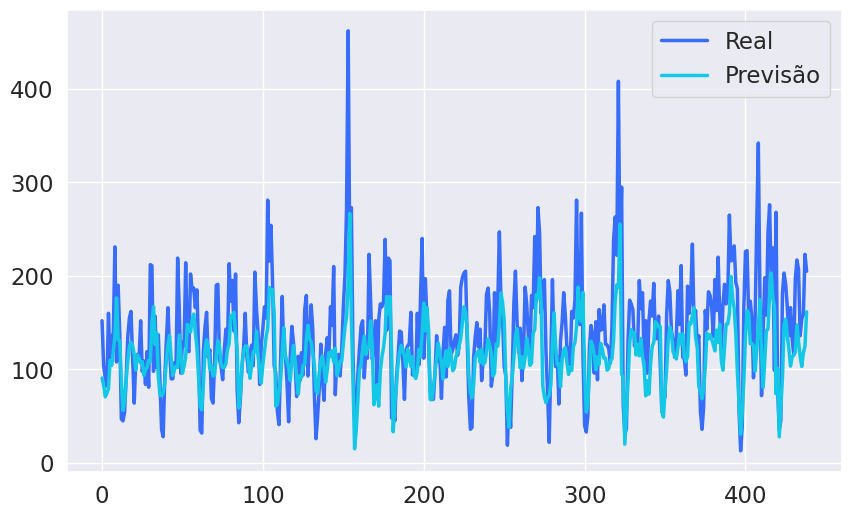

LSTM REQM: 51.2621


In [ ]:
# Construir o modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1)

# Fazer previsões
y_pred = model.predict(X_test)

# Desnormalizar os dados
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred)

# Plotar os resultados
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(y_test)), y_test, label='Real')
plt.plot(np.arange(len(y_pred)), y_pred, label='Previsão')
plt.legend()
plt.show()

# Calcular o REQM
lstm_reqm = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'LSTM REQM: {lstm_reqm:.4f}')

Epoch 1/30
112/112 [==============================] - 19s 137ms/step - loss: 0.0060 - val_loss: 0.0125
Epoch 2/30
112/112 [==============================] - 14s 128ms/step - loss: 0.0051 - val_loss: 0.0108
Epoch 3/30
112/112 [==============================] - 14s 128ms/step - loss: 0.0046 - val_loss: 0.0084
Epoch 4/30
112/112 [==============================] - 14s 127ms/step - loss: 0.0043 - val_loss: 0.0076
Epoch 5/30
112/112 [==============================] - 14s 127ms/step - loss: 0.0039 - val_loss: 0.0073
Epoch 6/30
112/112 [==============================] - 14s 128ms/step - loss: 0.0036 - val_loss: 0.0070
Epoch 7/30
112/112 [==============================] - 14s 128ms/step - loss: 0.0035 - val_loss: 0.0065
Epoch 8/30
112/112 [==============================] - 14s 128ms/step - loss: 0.0035 - val_loss: 0.0068
Epoch 9/30
112/112 [==============================] - 14s 128ms/step - loss: 0.0034 - val_loss: 0.0057
Epoch 10/30
112/112 [==============================] - 14s 128ms/step - l

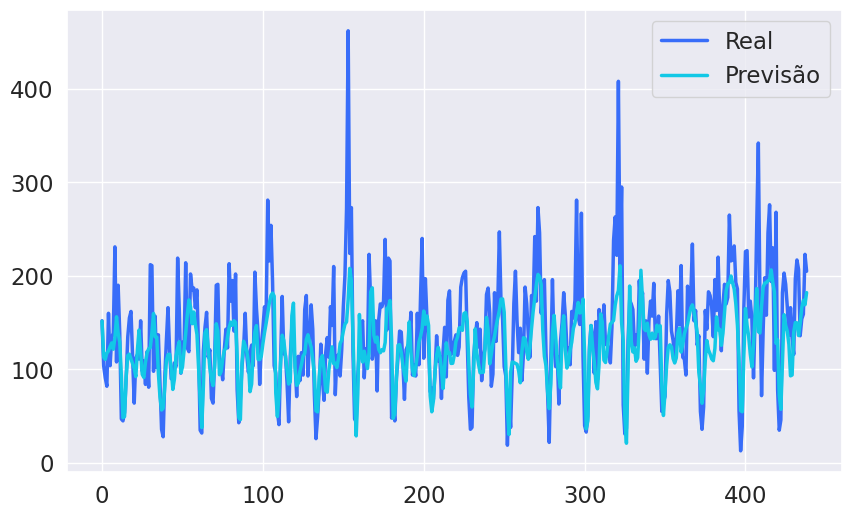

LSTM RMSE (ajustado): 45.5489


In [ ]:
# Normalizar os dados
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['num_orders']])

# Função para criar o dataset em formato de sequência
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Parâmetros
SEQ_LENGTH = 24  # Tamanho da sequência

# Criar o dataset de treino e teste
X, y = create_sequences(scaled_data, SEQ_LENGTH)
X_train, X_test = X[:-int(len(X) * 0.1)], X[-int(len(X) * 0.1):]
y_train, y_test = y[:-int(len(y) * 0.1)], y[-int(len(y) * 0.1):]

# Adicionar dimensão para LSTM [samples, time steps, features]
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Construir o modelo LSTM
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(SEQ_LENGTH, 1)))
model.add(LSTM(100))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1)

# Fazer previsões
y_pred = model.predict(X_test)

# Desnormalizar os dados
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred)

# Plotar os resultados
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(y_test)), y_test, label='Real')
plt.plot(np.arange(len(y_pred)), y_pred, label='Previsão')
plt.legend()
plt.show()

# Calcular o RMSE
lstm_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'LSTM RMSE (ajustado): {lstm_rmse:.4f}')

## Conclusão

A empresa Taxi Corrida Maluca solicitou a criação de um modelo preditivo para estimar o número de pedidos de táxi na próxima hora, utilizando dados históricos. O objetivo principal era desenvolver um modelo que apresentasse um Erro Quadrático Médio (REQM) menor que 48 no conjunto de teste, para que pudesse ser implementado em um sistema de previsão em tempo real.

Os modelos foram avaliados com base na métrica REQM utilizando o conjunto de teste. Os resultados foram os seguintes:

- SARIMA: REQM = 44.4601

- Prophet: REQM = 44.4765

- LSTM: REQM = 45.5489

Todos os modelos alcançaram um REQM inferior ao limite de 48 estabelecido como critério de sucesso.

Com base nos resultados, o modelo SARIMA é recomendado para implementação em produção, dada sua leve superioridade em precisão e sua natureza mais transparente e fácil de ajustar. O modelo Prophet pode ser considerado como uma alternativa, especialmente em cenários onde se deseje maior flexibilidade ou ajuste a múltiplas sazonalidades.